# Detrending CMIP6 models 

This notebook is the main processing pipeline to calculate control run drift, which can then be easily removed from historical+scenario runs. 

At this point it should be a thin wrapper around the [drift removal functionality](https://cmip6-preprocessing.readthedocs.io/en/latest/drift_removal.html) of [cmip6_preprocessing](https://github.com/jbusecke/cmip6_preprocessing).

## Notes
- [ ] THERE ARE DUPLICATE VERSIONS!
- [ ] Use the netcdf files for the final version. This is sooooooo slow!
- [ ] Delete temp folder

In [1]:
# starting from the raw data
import numpy as np
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import rechunk_to_temp
import intake
import pathlib
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import _match_datasets
from cmip6_preprocessing.drift_removal import calculate_drift
from cmip6_preprocessing.utils import cmip6_dataset_id

from xarrayutils.file_handling import write
from distributed import Client, LocalCluster

In [2]:
# cmip6_collection(zarr=False)

In [3]:
# # ok which dataset does not like the pp

# col = intake.open_esm_datastore(cmip6_collection(zarr=True)) # Takes wayyy to long for now
# kwargs = {
#     "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}},
#     "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
#     "aggregate": False,
# }
# regress_vars = ['agessc','thetao','o2', 'so', 'vo', 'epc100']
# cat = col.search(source_id=o2_models(), variable_id=regress_vars)#'CanESM5',["thetao"]

# ddict_historical_test = cat.search(experiment_id="historical").to_dataset_dict(**kwargs)
# for name, ds in ddict_historical_test.items():
#     try: 
#         combined_preprocessing(ds)
#     except:
#         print(name)

In [4]:
def debug_pp(ds):
    try:
        ds = combined_preprocessing(ds)
    except Exception as e:
        print(f"{cmip6_dataset_id(ds)} failed with ({e})")
    return ds

In [5]:
col = intake.open_esm_datastore(cmip6_collection(zarr=True)) # Takes wayyy to long for now
kwargs = {
#     "preprocess": combined_preprocessing,
    "preprocess": debug_pp,
    "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}},
    "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
    "aggregate": False,
}
regress_vars = ['agessc','thetao','o2', 'so', 'vo', 'epc100']
cat = col.search(source_id=o2_models(), variable_id=regress_vars)#'CanESM5',["thetao"]

ddict_historical = cat.search(experiment_id="historical").to_dataset_dict(**kwargs)
ddict_control = cat.search(experiment_id="piControl").to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f

In [6]:
# set up dask
# This is optimized so that 
mem_total = 350
workers = 10
threads = 4
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )

rechunk_mem = np.round(mem_total/workers/10)
rechunk_mem
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 10
Total threads: 40,Total memory: 325.96 GiB
Comm: tcp://127.0.0.1:40681,Workers: 10
Dashboard: http://127.0.0.1:9999/status,Total threads: 40
Started: Just now,Total memory: 325.96 GiB
Comm: tcp://127.0.0.1:38021,Total threads: 4
Dashboard: http://127.0.0.1:42152/status,Memory: 32.60 GiB
Nanny: tcp://127.0.0.1:45537,


## Main processing loop

In [9]:
def clean_attrs(ds):
    ds.attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname']}
    return ds

def clean_encoding(ds):
    for var in ds.variables:
        ds[var].encoding = {}
    return ds

In [10]:
missed_names = []

# This logic should make its way into cmip6_pp
ofolder = pathlib.Path("../../data/external/cmip6_control_drifts/")
tempfolder = pathlib.Path("../../data/temp/cmip6_control_drifts/")
trends = {}

for mi, (name, ds) in enumerate(ddict_historical.items()):
    print(f'#################{cmip6_dataset_id(ds)} ({mi}/{len(ddict_historical)+1})##################')
    # get potential matches

    rough_match = _match_datasets(
        ds,
        ddict_control,
        match_attrs=["source_id", "grid_label", "variable_id", "table_id"],
        pop=False,
    )

    # match parent attributes
    exact_match = []
    match_attrs_parent = ["variant_label", "source_id", "experiment_id"]
    for ds_match in rough_match:
        if all(
            [
                ds.attrs["parent_" + ma] == ds_match.attrs[ma]
                for ma in match_attrs_parent
            ]
        ):
            exact_match.append(ds_match)
    if len(exact_match) == 0:
        print("Did not find a match for ...")
    elif len(exact_match) > 1:
        raise RuntimeError(
            "This should not happen. Found more than one matching control run."
        )
    else:
        ds_parent = exact_match[0]
        
        
    try:
        # catch non match before calculating anything
        trend_dummy = calculate_drift(
            ds_parent, ds, ds.attrs["variable_id"],
        )
        
        

        # delete the encoding (I thought this was solved?) and the upsetting intake attrs 
        ds_parent = clean_attrs(clean_encoding(ds_parent))
        
        # rechunk the control run to make the calculation over time easier
        store_target = tempfolder.joinpath("rechunker_output.zarr")
        store_temp = tempfolder.joinpath("rechunker_temp.zarr")
        ds_parent_rechunked = rechunk_to_temp(ds_parent, store_target,store_temp=store_temp, mem=f'{rechunk_mem} GiB')
        
        # actually do the trend
        filepath = ofolder.joinpath(f"{cmip6_dataset_id(ds)}.{'_'.join(list(ds.data_vars))}.nc")
        trend = calculate_drift(
            ds_parent_rechunked, ds, ds.attrs["variable_id"],
        )
        trend_reloaded = write(
            trend,
            filepath,
            force_load=True,
            serialize_load_over_dim=False,
            overwrite=False,
        )
        trends[cmip6_dataset_id(ds)] = trend_reloaded
    except:
        missed_names.append(name)
        print(f"Could not match {cmip6_dataset_id(ds)}")

#################CMIP.NCC.NorESM2-MM.historical.r2i1p1f1.Omon.gr.none (0/1158)##################
reloading
$ Saving 0.077619692GB to ../../data/external/cmip6_control_drifts/CMIP.NCC.NorESM2-MM.historical.r2i1p1f1.Omon.gr.none.agessc.nc
Could not match CMIP.NCC.NorESM2-MM.historical.r2i1p1f1.Omon.gr.none
#################CMIP.NCC.NorCPM1.historical.r28i1p1f1.Omon.gr.none (1/1158)##################
Did not find a match for ...
Could not match CMIP.NCC.NorCPM1.historical.r28i1p1f1.Omon.gr.none
#################CMIP.NCC.NorCPM1.historical.r14i1p1f1.Omon.gn.none (2/1158)##################
Did not find a match for ...
Could not match CMIP.NCC.NorCPM1.historical.r14i1p1f1.Omon.gn.none
#################CMIP.NCC.NorCPM1.historical.r23i1p1f1.Omon.gn.none (3/1158)##################
Did not find a match for ...
Could not match CMIP.NCC.NorCPM1.historical.r23i1p1f1.Omon.gn.none
#################CMIP.NCC.NorCPM1.historical.r13i1p1f1.Omon.gr.none (4/1158)##################
Did not find a match for .

RuntimeError: This should not happen. Found more than one matching control run.

In [11]:
list([ds.attrs['intake_esm_dataset_key'] for ds in rough_match])

['CMIP.MOHC.UKESM1-0-LL.historical.r17i1p1f2.Omon.agessc.gn.v20191115./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r17i1p1f2/Omon/agessc/gn/v20191115/CMIP.MOHC.UKESM1-0-LL.historical.r17i1p1f2.Omon.agessc.gn.v20191115.zarr',
 'CMIP.MOHC.UKESM1-0-LL.piControl.r1i1p1f2.Omon.agessc.gn.v20190410./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Omon/agessc/gn/v20190410/CMIP.MOHC.UKESM1-0-LL.piControl.r1i1p1f2.Omon.agessc.gn.v20190410.zarr',
 'CMIP.MOHC.UKESM1-0-LL.piControl.r1i1p1f2.Omon.agessc.gn.v20190827./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Omon/agessc/gn/v20190827/CMIP.MOHC.UKESM1-0-LL.piControl.r1i1p1f2.Omon.agessc.gn.v20190827.zarr']

## Check the output data?

In [ ]:
# ddict_control_rechunked['CMIP.CCCma.CanESM5.piControl.r1i1p1f1.Omon.thetao.gn.v20190429./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Omon/thetao/gn/v20190429/CMIP.CCCma.CanESM5.piControl.r1i1p1f1.Omon.thetao.gn.v20190429.zarr']

In [ ]:
# trends['CMIP.CCCma.CanESM5.historical.r10i1p1f1.Omon.gn.v20190429']

In [ ]:
# for name, ds in trends.items():
#     filepath = ofolder.joinpath(f"{name}.{'_'.join(list(ds.data_vars))}.zarr")
    
#     ds.attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname']}
#     reg_reloaded = write(
#         ds,
#         filepath,
#         force_load=True,
#         serialize_load_over_dim=False,
#         overwrite=True,
#     )

In [1]:
# # %load_ext autoreload
# # %autoreload 2
# import shutil
# import warnings
# import intake
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt

# # from cmip6_omz.cmip6_preprocessing_stash import control_run_drift
# from euc_dynamics.cmip6_preprocessing_stash import single_member_trend as control_run_drift

# from xarrayutils.utils import xr_linregress

# # import the time tools
# from euc_dynamics.cmip6_preprocessing_stash import unify_time,get_ds_from_match, find_date_idx
# from euc_dynamics.utils import cmip6_collection,o2_models, member_treatment,scrub_encoding, pick_time, master_load, strip_all_but_var
# from euc_dynamics.file_handling import write, maybe_create_folder

# import dask
# # dask.config.set({"array.slicing.split_large_chunks": True, "array.chunk-size": "256 MiB"}) 
# dask.config.set({"array.slicing.split_large_chunks": False, "array.chunk-size": "256 MiB"}) 

ImportError: cannot import name 'find_date_idx' from 'euc_dynamics.cmip6_preprocessing_stash' (/projects/GEOCLIM/LRGROUP/jbusecke/projects/euc_dynamics/euc_dynamics/cmip6_preprocessing_stash.py)

In [10]:
# col.search(
#         source_id=[
# #         "UKESM1-0-LL", # area not available for all members
# #         "MRI-ESM2-0", # 
# #         "NorESM2-LM",
# #         "NorESM2-MM",
#         "GFDL-ESM4",
#         "GFDL-CM4",
#         "MIROC-ES2L", # done
#         "CNRM-ESM2-1", # done bunch of members have missing thetao
#         "CanESM5", # done
# #         "CanESM5-CanOE", # done
# #         "MPI-ESM1-2-HR", # done
# #         "ACCESS-ESM1-5", # done
# #         "IPSL-CM6A-LR", # done
# #         "NorESM1-F", #meh, dont need it
# #         "NorCPM1", #meh, dont need it
# #         "MPI-ESM-1-2-HAM", # done
# #         "MPI-ESM1-2-LR", # done
#     ],
#     grid_label=["gr", "gn"],
# #     experiment_id=["historical", "piControl"],
#     experiment_id=["historical"],
#     table_id=["Omon"],
#     variable_id=regress_vars,
# ).df['zstore'].tolist()

In [11]:
# ddict = load_single_datasets(
#     col,
#     source_id=[
#         "UKESM1-0-LL", # area not available for all members
#         "MRI-ESM2-0", # 
#         "NorESM2-LM",
#         "NorESM2-MM",
#         "GFDL-ESM4",
#         "GFDL-CM4",
#         "MIROC-ES2L", # done
#         "CNRM-ESM2-1", # done bunch of members have missing thetao
#         "CanESM5", # done
#         "CanESM5-CanOE", # done
#         "MPI-ESM1-2-HR", # done
#         "ACCESS-ESM1-5", # done
#         "IPSL-CM6A-LR", # done
#         "NorESM1-F", #meh, dont need it
#         "NorCPM1", #meh, dont need it
#         "MPI-ESM-1-2-HAM", # done
#         "MPI-ESM1-2-LR", # done
#     ],
#     grid_label=["gr", "gn"],
# #     experiment_id=["historical", "piControl"],
#     experiment_id=["historical"],
#     table_id=["Omon"],
#     variable_id=regress_vars,
# )

In [12]:
# xr.open_zarr('/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6_zarr_links/CMIP6_tigercpu/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r3i1p1f2/Omon/thetao/gn/v20190125/CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r3i1p1f2.Omon.thetao.gn.v20190125.zarr')

## Main computation

In [13]:
# from aguadv_omz_busecke_2021.rechunker_tools import rechunk_to_temp

In [14]:
# calculates trends
overwrite = False
fname_scheme = "{ds_id}_{member}_{var}_trend.nc"
for model in o2_models():
    for var in super_dict.keys():
        subdict = super_dict[var]
        for grid_label in ["gn", "gr"]:

            print(
                f"######################### {model} {var} {grid_label} ##########################"
            )

            control = get_ds_from_match(subdict, [model, grid_label, "piControl"])
            hist = get_ds_from_match(subdict, [model, grid_label, "historical"])

            if control is not None:
                if "rho" in control.dims:
                    control = None  # Kill that one. I will have to check that in detail

            if control is None or hist is None:
                print("WAHHHHHH 🙀 No data found")
            else:

                control = control[[var]]
                # add lon/lat back in as a safeguard for later if I decide to change the way the sorting is done again...
                
                control = control.drop(
                    [dv for dv in ["time_bounds"] if dv in control.variables]
                )
                control = control.unify_chunks().chunk(
                    {
                        k: v
                        for k, v in {"time": 3, "x": -1, "y": -1, "lev": -1}.items()
                        if k in control.dims
                    }
                )
                # Check here if all possible members are already saved and skip if so!
                
                members = hist.member_id.data
                filelist = [ofolder.joinpath(fname_scheme.format(ds_id=cmip6_dataset_id(hist), member=me, var=var)) for me in members]
                with ProgressBar():
                    if all([f.exists() for f in filelist]):
                        print("All files exist already. Skip the rechunking. 🚀")
                    else:
                        # rechunk and write out the control run with better chunks
                        print("rechunker magic...🦄")
                        store_target = ofolder.joinpath("rechunker_output.zarr")
                        store_temp = ofolder.joinpath("rechunker_temp.zarr")
                        control = rechunk_to_temp(control, store_target,store_temp=store_temp, mem='512 MiB')
                        print("rechunker magic...🦄 Done")

                        if control is None or hist is None:
                            print(f"Could not find all runs for {model}|{grid_label}|{var}")
                        else:
                            print(f"Processing {model}|{grid_label}|{var}")
                            if "lev" in control.dims or (
                                set(control.dims).issubset(
                                    set(["x", "y", "member_id", "time", "bnds", "vertex"])
                                )
                            ):  # exclude the norwegian rho gn models
                                for mi, (member, filename) in enumerate(zip(members, filelist)):
                                    print(f"{member}: {mi+1}/{len(members)}")
                                    filename = ofolder.joinpath(
                                        f"{cmip6_dataset_id(hist)}_{member}_{var}_trend.nc"
                                    )

                                    if filename.exists():
                                        print("Skippedy Doo.")
                                    else:
                                        print("regression")
                                        reg = single_member_trend(
                                            control[var], hist[var].sel(member_id=member)
                                        )
                                        if reg is None:
                                            print('Unable to reconstruct Regression')
                                        else:
                                            reg = reg.chunk({"x": -1, "y": -1, "lev": -1})
                                            with ProgressBar():
                                                reg_reloaded = write(
                                                    reg,
                                                    filename,
                                                    force_load=True,
                                                    serialize_load_over_dim=False,
                                                    overwrite=False,
                                                )
                            print("\n\n\n\n\n")

######################### CanESM5-CanOE vo gn ##########################
WAHHHHHH 🙀 No data found
######################### CanESM5-CanOE vo gr ##########################
WAHHHHHH 🙀 No data found
######################### CanESM5 vo gn ##########################
WAHHHHHH 🙀 No data found
######################### CanESM5 vo gr ##########################
WAHHHHHH 🙀 No data found
######################### CNRM-ESM2-1 vo gn ##########################
WAHHHHHH 🙀 No data found
######################### CNRM-ESM2-1 vo gr ##########################
WAHHHHHH 🙀 No data found
######################### ACCESS-ESM1-5 vo gn ##########################
WAHHHHHH 🙀 No data found
######################### ACCESS-ESM1-5 vo gr ##########################
WAHHHHHH 🙀 No data found
######################### MPI-ESM-1-2-HAM vo gn ##########################
WAHHHHHH 🙀 No data found
######################### MPI-ESM-1-2-HAM vo gr ##########################
WAHHHHHH 🙀 No data found
######################### IPSL-C

In [15]:
store_target

NameError: name 'store_target' is not defined

Delete the last temp output

In [ ]:
shutil.rmtree(store_target)

### Quick investigation, why GFDL age is empty

Its just the beginning? But still weird....

In [8]:
import xarray as xr
ds_test = xr.open_dataset('/home/jbusecke/projects/aguadv_omz_busecke_2021/data/processed/linear_regression_time_zarr_multimember/CMIP_NOAA-GFDL_GFDL-CM4_historical_Omon_gn_none_r1i1p1f1_agessc_trend.nc')

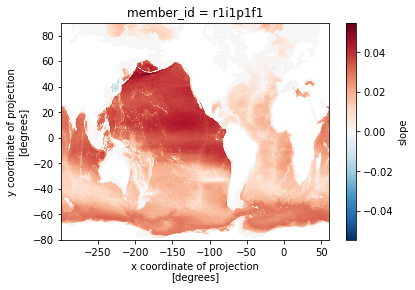

In [9]:
ds_test.slope.mean('lev').plot()

In [19]:
source_ids = ["GFDL-CM4", 'GFDL-ESM4']
# source_ids = ['ACCESS-ESM1-5', "CanESM5"]
# source_ids = ["CanESM5-CanOE", 'GFDL-ESM4', 'GFDL-CM4']


super_dict_time = master_load(
    variable_ids=['agessc'],
    experiment_ids = ['historical', 'ssp585'],
    source_ids=source_ids, 
#     detrend_datasets=True,
    detrend_datasets=False,
    detrend_source_path='../../data/processed/linear_regression_time_zarr_multimember',
    array_chunk_size='512 MiB',
)

Dataset(s):   0%|                                        | 0/4 [00:00<?, ?it/s]

Reading agessc for all models

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s): 100%|████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]


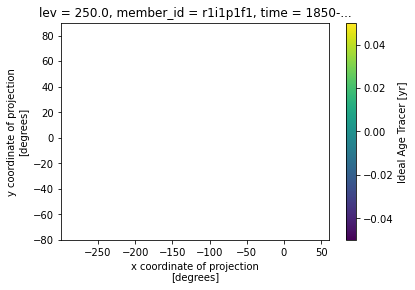

In [20]:
super_dict_time['agessc']['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn'].agessc.isel(time=0,lev=10).plot()

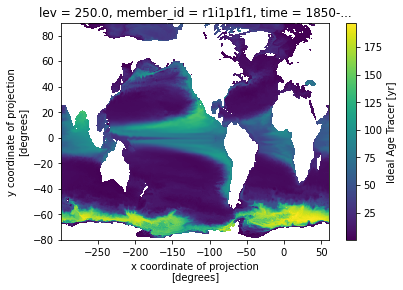

In [21]:
super_dict_time['agessc']['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn'].agessc.isel(time=10,lev=10).plot()

### Check each file if it is all nan in one dimension....

The all nans are incomplete writes and should be deleted.

In [16]:
#check all files
# eliminate all nan files first
flist = ofolder.glob('*trend.nc')
for f in flist:
#     print(f)
    ds = xr.open_dataset(f)
    trigger = True
    for var in ['slope', 'intercept']:
        if trigger:
#             if np.isnan(ds[var].squeeze()).all(['lev','x','y']):
              # loosen the criteria to more than 50% nans?
            if np.sum(np.isnan(ds[var].squeeze())).load().data > 0.9 * np.prod(ds[var].squeeze().shape):
#                 f.unlink()
                print(f" Removed all nan ({var}) file {f.name}.")
                trigger=False
#             elif np.sum(ds[var].squeeze() == 0).load().data > 0.8 * np.prod(ds[var].squeeze().shape):
# #                 f.unlink()
#                 print(f" Removed all zero ({var}) file {f.name}.")
#                 trigger=False

 Removed all nan (slope) file CanESM5.gn_r24i1p1f1_no3_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r24i1p1f1_so_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r25i1p1f1_so_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r25i1p1f1_thetao_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r22i1p1f1_thetao_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r24i1p1f1_thetao_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r25i1p1f1_no3_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r24i1p1f1_o2_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r22i1p1f1_so_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r22i1p1f1_agessc_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r23i1p1f1_vo_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r23i1p1f1_so_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r24i1p1f1_vo_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r25i1p1f1_o2_trend.nc.
 Removed all nan (slope) file CanESM5.gn_r25i1p1f1_epc100_trend.nc.
 Removed all nan (

Are these all nans in the source? What the hell?

## Some bug? But I dont remember quite what it was?

In [ ]:
super_dict_time_raw = master_load(
#     variable_ids=["thetao", "so", "o2", "vo", "uo", "agessc"],
    variable_ids=["thetao"],
    source_ids=['GFDL-ESM4'], 
    detrend_datasets=False,
    detrend_source_path='../data/processed/linear_regression_time_zarr_multimember3',
    array_chunk_size='512 MiB',
)

In [ ]:
super_dict_time_raw['thetao']['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn'].thetao.isel(time=0, member_id=0, lev=20).plot()